In [1]:
# relevant libraries
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:,.2f}'.format)

In [2]:
# import dataset
df = pd.read_csv('cluster_result.csv',index_col = 0)
df.head()

,CUSTOMER_SITE_ID,Recency,Frequency,Num_of_Trxns,Avg_Trxn_Amt,Avg_Margin,Avg_Quantity,Mode_of_Product_Family,Mode_of_Product_Model,Types_of_Product_Family,Types_of_Product_Model,Most_Frequent_Sales_Channel,Most_Frequent_Order_Type,Avg_Price_Index,SHORT_VERTICAL,POSTAL_CODE,CUSTOMER_CLASS,TERRITORY_TYPE,SUPPLIES_SEGMENTATION,SUPPLIES_DECLINE_REASONS,DUNS_NUMBER,Total_SVC_Incidents,Total_Repeat_Calls,Total_FTF_Calls,Most_Frequent_Interaction_Type,Total_Visits,Total_Cases,Num_of_Active_Install_Bases,Total_Contracts,Contract_length,Contract_Category,STRATEGIC_ACCOUNTS,TERRITORY_REGION,Tenure,Cluster_Id,Churned_365
0,24,24,17.67,4,"3,102.11","2,901.24",12.00,LCM,INK,2,2,Copy,STANDARD DOMESTIC,0.79,GRAPHICS,60085,END USER,Industrial,S,None,144782380,13.00,7.00,6.00,Call,81.00,1.97,5.00,0.00,0.00,No Contract,0,MW,77.00,3,0
1,90,50,18.86,98,233.90,172.39,11.37,CIJ,MAKE-UP,1,3,EDI,EDI,1.35,CHEMICALS,65802,END USER,Industrial,S,None,43937895,57.00,13.00,44.00,Call,53.00,3.03,6.00,6.00,"1,003.00",FSMA,0,MC,"1,879.00",3,0
2,111,415,72.85,21,220.75,188.43,1.05,CIJ,MAKE-UP,1,2,EDI,EDI,1.28,GRAPHICS,56073,END USER,Industrial,S,None,119130057,1.00,0.00,1.00,Call,22.00,3.03,2.00,0.00,0.00,No Contract,0,MW,"1,457.00",1,1
3,114,6,11.38,174,145.43,103.28,4.43,CIJ,MAKE-UP,3,4,EDI,EDI,1.25,PHARMA & MEDICAL,92614,END USER,Industrial,M,None,84160407,57.00,14.00,43.00,Call,70.00,1.00,15.00,11.00,521.64,FSMA,0,NW,"1,974.00",3,0
4,126,49,61.94,19,835.78,605.25,8.84,TIJ,INK,1,1,EDI,EDI,0.75,PHARMA & MEDICAL,8822,END USER,Industrial,S,Over Stocked / Timing,36781508,1.00,0.00,1.00,Call,13.00,1.00,2.00,0.00,0.00,No Contract,0,NE,"1,164.00",2,0


# Predicting churn using lifetimes package

In [3]:
# copy columns that would be used
data = df[['CUSTOMER_SITE_ID','Num_of_Trxns','Tenure','Recency','Churned_365']]

In [4]:
# reformat data to match the package requirement
data = data.set_index(['CUSTOMER_SITE_ID'])

data['frequency'] = data['Num_of_Trxns'] - 1
data['T'] = np.where(data['Churned_365'] == 1, data['Tenure'] + data['Recency'], data['Tenure'])
data['recency'] = np.where(data['Churned_365'] == 1, data['Tenure'], data['Tenure'] - data['Recency'])

data = data.drop(columns = ['Tenure','Recency','Num_of_Trxns'])

- `frequency`: the number of repeat purchases the customer has made. 

- `T`: the duration between a customer’s first purchase and the end of the period under study. 

- `recency` the duration between a customer’s first purchase and their latest purchase. 

In [5]:
data.head()

,Churned_365,frequency,T,recency
CUSTOMER_SITE_ID,,,,
24,0,3,77.00,53.00
90,0,97,"1,879.00","1,829.00"
111,1,20,"1,872.00","1,457.00"
114,0,173,"1,974.00","1,968.00"
126,0,18,"1,164.00","1,115.00"


## Fitting a BG-NBD model

BG-NBD(Beta Geometric Negative Binomial Distribution) model has the following assumptions:

1) While active, transactions made by a customer in time period $t$ is __Poisson__ distributed with mean $\lambda t$

2) Differences in transaction rate between customers follows a __gamma__ distribution with shape $r$ and scale $\alpha$

3) Each customer becomes inactive after each transaction with probability $p$

4) Differences in $p$ follows a __beta__ distribution with shape parameters $a$ and $b$

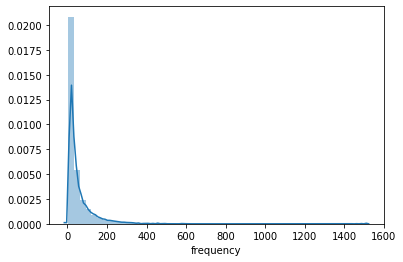

In [6]:
sns.distplot(data.frequency)

In [7]:
# fit a model
from lifetimes import ModifiedBetaGeoFitter

mbgf = ModifiedBetaGeoFitter(penalizer_coef = 0.001)
mbgf.fit(data['frequency'], data['recency'], data['T'], verbose = True)
display(mbgf)

Optimization terminated successfully.
         Current function value: -161.996609
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28


<lifetimes.ModifiedBetaGeoFitter: fitted with 8367 subjects, a: 0.12, alpha: 30.11, b: 3.25, r: 1.06>

In [8]:
# fitted model parameters
mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.06,0.02,1.03,1.09
alpha,30.11,0.62,28.89,31.34
a,0.12,0.00,0.12,0.13
b,3.25,0.13,2.99,3.51


## Assessing model fit

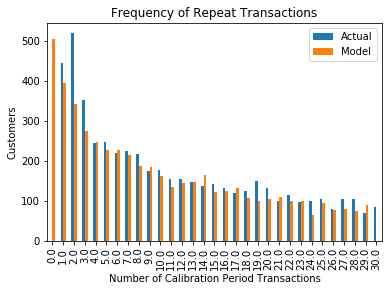

In [9]:
np.random.seed(1)

from lifetimes.plotting import plot_period_transactions

plot_period_transactions(mbgf, max_frequency = 30)

# this plot compares between original data and 
# the artificial data simulated with the fitted model’s parameters

In [10]:
# create simulate data
np.random.seed(1)

model = mbgf

n = model.data.shape[0]
simulated_data = model.generate_new_data(size=n)

model_counts = pd.DataFrame(model.data["frequency"].value_counts().sort_index())
simulated_counts = pd.DataFrame(simulated_data["frequency"].value_counts().sort_index())
combined_counts = model_counts.merge(simulated_counts, how="outer", left_index=True, right_index=True).fillna(0)
combined_counts.columns = ["Actual", "Model"]  
combined_counts = combined_counts[combined_counts.Actual != 0]

In [11]:
# compute 
diff = abs(combined_counts.Actual.iloc[:100] - combined_counts.Model.iloc[:100])

In [12]:
# compute MAPE MAD
MAPE = round((diff/combined_counts.Actual.iloc[:100]).mean(),2)

MAD = diff.mean()
print(f'MAPE: {MAPE}, MAD: {MAD}')


MAPE: 0.25, MAD: 11.98


## Predicting alive probability

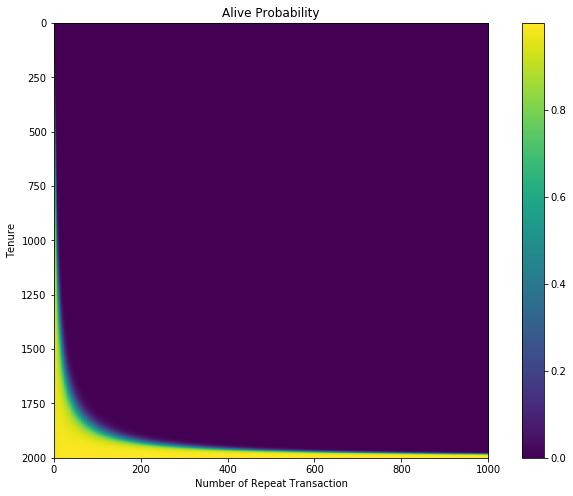

In [13]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(mbgf, max_recency = 2000, max_frequency = 1000,
                             title = 'Alive Probability',
                             xlabel = 'Number of Repeat Transaction',
                             ylabel = 'Tenure')

Text(0, 0.5, 'Number of Customers')

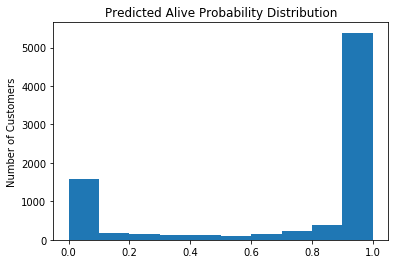

In [14]:
# distribution of alive probability
data['alive_prob'] = mbgf.conditional_probability_alive(data['frequency'], data['recency'], data['T'])
data['alive_prob'].plot.hist()
plt.title('Predicted Alive Probability Distribution')
plt.ylabel('Number of Customers')

In [15]:
data.head()

,Churned_365,frequency,T,recency,alive_prob
CUSTOMER_SITE_ID,,,,,
24,0,3,77.00,53.00,0.95
90,0,97,"1,879.00","1,829.00",0.98
111,1,20,"1,872.00","1,457.00",0.51
114,0,173,"1,974.00","1,968.00",1.00
126,0,18,"1,164.00","1,115.00",0.99


In [16]:
data = data.reset_index()

In [17]:
data.head()

,CUSTOMER_SITE_ID,Churned_365,frequency,T,recency,alive_prob
0,24,0,3,77.00,53.00,0.95
1,90,0,97,"1,879.00","1,829.00",0.98
2,111,1,20,"1,872.00","1,457.00",0.51
3,114,0,173,"1,974.00","1,968.00",1.00
4,126,0,18,"1,164.00","1,115.00",0.99


In [18]:
# calculate churn probability
data['churn_prob_BGNBD'] = 1-data['alive_prob']

## Creating churn variable based on prediction

In [19]:
df = pd.concat([df, data['churn_prob_BGNBD']], axis = 1)
temp = df['Churned_365']
df.drop('Churned_365',axis = 1,inplace = True)
df['Churned_365'] = temp

df.head()

,CUSTOMER_SITE_ID,Recency,Frequency,Num_of_Trxns,Avg_Trxn_Amt,Avg_Margin,Avg_Quantity,Mode_of_Product_Family,Mode_of_Product_Model,Types_of_Product_Family,Types_of_Product_Model,Most_Frequent_Sales_Channel,Most_Frequent_Order_Type,Avg_Price_Index,SHORT_VERTICAL,POSTAL_CODE,CUSTOMER_CLASS,TERRITORY_TYPE,SUPPLIES_SEGMENTATION,SUPPLIES_DECLINE_REASONS,DUNS_NUMBER,Total_SVC_Incidents,Total_Repeat_Calls,Total_FTF_Calls,Most_Frequent_Interaction_Type,Total_Visits,Total_Cases,Num_of_Active_Install_Bases,Total_Contracts,Contract_length,Contract_Category,STRATEGIC_ACCOUNTS,TERRITORY_REGION,Tenure,Cluster_Id,churn_prob_BGNBD,Churned_365
0,24,24,17.67,4,"3,102.11","2,901.24",12.00,LCM,INK,2,2,Copy,STANDARD DOMESTIC,0.79,GRAPHICS,60085,END USER,Industrial,S,None,144782380,13.00,7.00,6.00,Call,81.00,1.97,5.00,0.00,0.00,No Contract,0,MW,77.00,3,0.05,0
1,90,50,18.86,98,233.90,172.39,11.37,CIJ,MAKE-UP,1,3,EDI,EDI,1.35,CHEMICALS,65802,END USER,Industrial,S,None,43937895,57.00,13.00,44.00,Call,53.00,3.03,6.00,6.00,"1,003.00",FSMA,0,MC,"1,879.00",3,0.02,0
2,111,415,72.85,21,220.75,188.43,1.05,CIJ,MAKE-UP,1,2,EDI,EDI,1.28,GRAPHICS,56073,END USER,Industrial,S,None,119130057,1.00,0.00,1.00,Call,22.00,3.03,2.00,0.00,0.00,No Contract,0,MW,"1,457.00",1,0.49,1
3,114,6,11.38,174,145.43,103.28,4.43,CIJ,MAKE-UP,3,4,EDI,EDI,1.25,PHARMA & MEDICAL,92614,END USER,Industrial,M,None,84160407,57.00,14.00,43.00,Call,70.00,1.00,15.00,11.00,521.64,FSMA,0,NW,"1,974.00",3,0.00,0
4,126,49,61.94,19,835.78,605.25,8.84,TIJ,INK,1,1,EDI,EDI,0.75,PHARMA & MEDICAL,8822,END USER,Industrial,S,Over Stocked / Timing,36781508,1.00,0.00,1.00,Call,13.00,1.00,2.00,0.00,0.00,No Contract,0,NE,"1,164.00",2,0.01,0


In [20]:
df['Churned_365'].value_counts()

0    6147
1    2220
Name: Churned_365, dtype: int64

In [21]:
df['Churned_365'].sum()/len(df['Churned_365'])

0.26532807457870206

Threshold value is: 0.11933220611087714


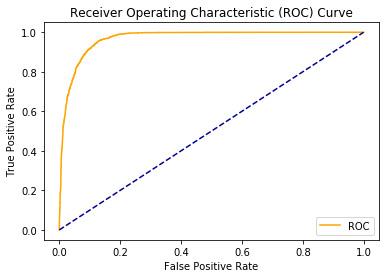

In [22]:
from sklearn.metrics import roc_curve,roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array(df['Churned_365'])
y_scores = np.array(df['churn_prob_BGNBD'])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [23]:
df['Churned_BGNBD'] = (df['churn_prob_BGNBD'] > optimal_threshold).replace({False: 0, True: 1})

In [24]:
df.head()

,CUSTOMER_SITE_ID,Recency,Frequency,Num_of_Trxns,Avg_Trxn_Amt,Avg_Margin,Avg_Quantity,Mode_of_Product_Family,Mode_of_Product_Model,Types_of_Product_Family,Types_of_Product_Model,Most_Frequent_Sales_Channel,Most_Frequent_Order_Type,Avg_Price_Index,SHORT_VERTICAL,POSTAL_CODE,CUSTOMER_CLASS,TERRITORY_TYPE,SUPPLIES_SEGMENTATION,SUPPLIES_DECLINE_REASONS,DUNS_NUMBER,Total_SVC_Incidents,Total_Repeat_Calls,Total_FTF_Calls,Most_Frequent_Interaction_Type,Total_Visits,Total_Cases,Num_of_Active_Install_Bases,Total_Contracts,Contract_length,Contract_Category,STRATEGIC_ACCOUNTS,TERRITORY_REGION,Tenure,Cluster_Id,churn_prob_BGNBD,Churned_365,Churned_BGNBD
0,24,24,17.67,4,"3,102.11","2,901.24",12.00,LCM,INK,2,2,Copy,STANDARD DOMESTIC,0.79,GRAPHICS,60085,END USER,Industrial,S,None,144782380,13.00,7.00,6.00,Call,81.00,1.97,5.00,0.00,0.00,No Contract,0,MW,77.00,3,0.05,0,0
1,90,50,18.86,98,233.90,172.39,11.37,CIJ,MAKE-UP,1,3,EDI,EDI,1.35,CHEMICALS,65802,END USER,Industrial,S,None,43937895,57.00,13.00,44.00,Call,53.00,3.03,6.00,6.00,"1,003.00",FSMA,0,MC,"1,879.00",3,0.02,0,0
2,111,415,72.85,21,220.75,188.43,1.05,CIJ,MAKE-UP,1,2,EDI,EDI,1.28,GRAPHICS,56073,END USER,Industrial,S,None,119130057,1.00,0.00,1.00,Call,22.00,3.03,2.00,0.00,0.00,No Contract,0,MW,"1,457.00",1,0.49,1,1
3,114,6,11.38,174,145.43,103.28,4.43,CIJ,MAKE-UP,3,4,EDI,EDI,1.25,PHARMA & MEDICAL,92614,END USER,Industrial,M,None,84160407,57.00,14.00,43.00,Call,70.00,1.00,15.00,11.00,521.64,FSMA,0,NW,"1,974.00",3,0.00,0,0
4,126,49,61.94,19,835.78,605.25,8.84,TIJ,INK,1,1,EDI,EDI,0.75,PHARMA & MEDICAL,8822,END USER,Industrial,S,Over Stocked / Timing,36781508,1.00,0.00,1.00,Call,13.00,1.00,2.00,0.00,0.00,No Contract,0,NE,"1,164.00",2,0.01,0,0


In [25]:
(df['Churned_BGNBD'] == df['Churned_365']).mean()

0.8953029759770527

In [26]:
df.to_csv("variables_with_churn.csv")

## Finding top customers with highest churn probability

In [27]:
# keep only customers who have purchased in the past 1 year
recent_1yr = df[df['Recency'] < 365]

In [28]:
potential_churn = recent_1yr[recent_1yr['churn_prob_BGNBD'] > 0.95].sort_values(by = ['Avg_Margin'], ascending = False)

In [29]:
recent_1yr.head()

,CUSTOMER_SITE_ID,Recency,Frequency,Num_of_Trxns,Avg_Trxn_Amt,Avg_Margin,Avg_Quantity,Mode_of_Product_Family,Mode_of_Product_Model,Types_of_Product_Family,Types_of_Product_Model,Most_Frequent_Sales_Channel,Most_Frequent_Order_Type,Avg_Price_Index,SHORT_VERTICAL,POSTAL_CODE,CUSTOMER_CLASS,TERRITORY_TYPE,SUPPLIES_SEGMENTATION,SUPPLIES_DECLINE_REASONS,DUNS_NUMBER,Total_SVC_Incidents,Total_Repeat_Calls,Total_FTF_Calls,Most_Frequent_Interaction_Type,Total_Visits,Total_Cases,Num_of_Active_Install_Bases,Total_Contracts,Contract_length,Contract_Category,STRATEGIC_ACCOUNTS,TERRITORY_REGION,Tenure,Cluster_Id,churn_prob_BGNBD,Churned_365,Churned_BGNBD
0,24,24,17.67,4,"3,102.11","2,901.24",12.00,LCM,INK,2,2,Copy,STANDARD DOMESTIC,0.79,GRAPHICS,60085,END USER,Industrial,S,None,144782380,13.00,7.00,6.00,Call,81.00,1.97,5.00,0.00,0.00,No Contract,0,MW,77.00,3,0.05,0,0
1,90,50,18.86,98,233.90,172.39,11.37,CIJ,MAKE-UP,1,3,EDI,EDI,1.35,CHEMICALS,65802,END USER,Industrial,S,None,43937895,57.00,13.00,44.00,Call,53.00,3.03,6.00,6.00,"1,003.00",FSMA,0,MC,"1,879.00",3,0.02,0,0
3,114,6,11.38,174,145.43,103.28,4.43,CIJ,MAKE-UP,3,4,EDI,EDI,1.25,PHARMA & MEDICAL,92614,END USER,Industrial,M,None,84160407,57.00,14.00,43.00,Call,70.00,1.00,15.00,11.00,521.64,FSMA,0,NW,"1,974.00",3,0.00,0,0
4,126,49,61.94,19,835.78,605.25,8.84,TIJ,INK,1,1,EDI,EDI,0.75,PHARMA & MEDICAL,8822,END USER,Industrial,S,Over Stocked / Timing,36781508,1.00,0.00,1.00,Call,13.00,1.00,2.00,0.00,0.00,No Contract,0,NE,"1,164.00",2,0.01,0,0
5,141,80,20.69,92,720.52,556.79,38.05,CIJ,MAKE-UP,1,3,Esker,STANDARD DOMESTIC,1.05,OTHER,98903,END USER,Industrial,L,Migration to 1000 Line/TIJ/TTO/LCM/LPA,832676089,124.00,31.00,93.00,Email,50.00,1.97,15.00,15.00,364.00,FSMA,0,NW,"1,963.00",3,0.05,0,0


In [30]:
potential_churn = potential_churn [['CUSTOMER_SITE_ID','Recency','Frequency','Tenure','Avg_Trxn_Amt','Avg_Margin','Num_of_Trxns','Cluster_Id']]
potential_churn['Total_Trxn_Amt'] = potential_churn['Avg_Trxn_Amt'] * potential_churn['Num_of_Trxns']
potential_churn['Total_Margin'] = potential_churn['Avg_Margin'] * potential_churn['Num_of_Trxns']
temp = potential_churn['Cluster_Id']
potential_churn.drop('Cluster_Id',axis = 1,inplace = True)
potential_churn['Cluster_Id'] = temp

potential_churn.head()

,CUSTOMER_SITE_ID,Recency,Frequency,Tenure,Avg_Trxn_Amt,Avg_Margin,Num_of_Trxns,Total_Trxn_Amt,Total_Margin,Cluster_Id
8096,8386636,259,13.50,367.00,"4,420.03","3,916.73",9,"39,780.25","35,250.53",3
2649,113342,358,20.04,"1,981.00","5,706.04","2,762.46",82,"467,895.58","226,521.70",2
7563,8336697,360,22.47,742.00,"2,581.83","2,313.56",18,"46,472.98","41,644.00",3
1103,34151,128,8.15,"1,971.00","1,882.71","1,506.53",227,"427,374.75","341,982.00",3
5613,695136,251,19.85,"1,978.00","1,277.68","1,204.66",88,"112,436.25","106,009.82",3


In [31]:
cluster_segment = pd.DataFrame(potential_churn.groupby(['Cluster_Id'])['Total_Margin'].mean())
cluster_segment['rank(1-top_priority)'] = cluster_segment['Total_Margin'].rank(ascending=False)
cluster_segment = cluster_segment.reset_index()
cluster_segment = cluster_segment.drop('Total_Margin',axis = 1)
cluster_segment

,Cluster_Id,rank(1-top_priority)
0,0,4.00
1,1,3.00
2,2,1.00
3,3,2.00


In [32]:
potential_churn = potential_churn.merge(cluster_segment, on='Cluster_Id', how='left')
potential_churn = potential_churn.sort_values(["rank(1-top_priority)", "Total_Margin"], ascending = (True, False))
potential_churn

,CUSTOMER_SITE_ID,Recency,Frequency,Tenure,Avg_Trxn_Amt,Avg_Margin,Num_of_Trxns,Total_Trxn_Amt,Total_Margin,Cluster_Id,rank(1-top_priority)
1,113342,358,20.04,"1,981.00","5,706.04","2,762.46",82,"467,895.58","226,521.70",2,1.00
13,71033,289,25.62,"1,665.00","3,324.54",763.45,66,"219,419.96","50,387.95",2,1.00
18,89579,357,26.95,"1,617.00","2,491.63",683.60,61,"151,989.26","41,699.77",2,1.00
3,34151,128,8.15,"1,971.00","1,882.71","1,506.53",227,"427,374.75","341,982.00",3,2.00
21,36080,317,6.81,"1,978.00",843.69,657.77,245,"206,705.11","161,154.53",3,2.00
7,29598,273,12.07,"1,963.00","1,145.61","1,063.22",141,"161,530.36","149,913.90",3,2.00
8,198762,240,11.68,"1,694.00","1,093.82",951.75,146,"159,697.09","138,954.94",3,2.00
4,695136,251,19.85,"1,978.00","1,277.68","1,204.66",88,"112,436.25","106,009.82",3,2.00
51,735,161,5.83,"1,974.00",381.78,331.30,312,"119,114.60","103,366.09",3,2.00
53,5768,80,5.88,"1,963.00",427.33,319.99,321,"137,173.23","102,715.47",3,2.00


In [33]:
potential_churn.groupby("rank(1-top_priority)")['Total_Margin'].mean()

rank(1-top_priority)
1.00   106,203.14
2.00    41,114.32
3.00     5,576.54
4.00       763.91
Name: Total_Margin, dtype: float64

In [34]:
potential_churn.drop(['Avg_Trxn_Amt','Avg_Margin'],axis = 1,inplace = True)

In [35]:
# removing rows with 0 Frequency if any

potential_churn = potential_churn.astype(int)
potential_churn = potential_churn[potential_churn["Frequency"] > 0]
potential_churn

,CUSTOMER_SITE_ID,Recency,Frequency,Tenure,Num_of_Trxns,Total_Trxn_Amt,Total_Margin,Cluster_Id,rank(1-top_priority)
1,113342,358,20,1981,82,467895,226521,2,1
13,71033,289,25,1665,66,219419,50387,2,1
18,89579,357,26,1617,61,151989,41699,2,1
3,34151,128,8,1971,227,427374,341982,3,2
21,36080,317,6,1978,245,206705,161154,3,2
7,29598,273,12,1963,141,161530,149913,3,2
8,198762,240,11,1694,146,159697,138954,3,2
4,695136,251,19,1978,88,112436,106009,3,2
51,735,161,5,1974,312,119114,103366,3,2
53,5768,80,5,1963,321,137173,102715,3,2


In [36]:
potential_churn.to_csv('potential_churn_customers.csv', index = False)